In [41]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:] 
print(header) 
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [42]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1)) 
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

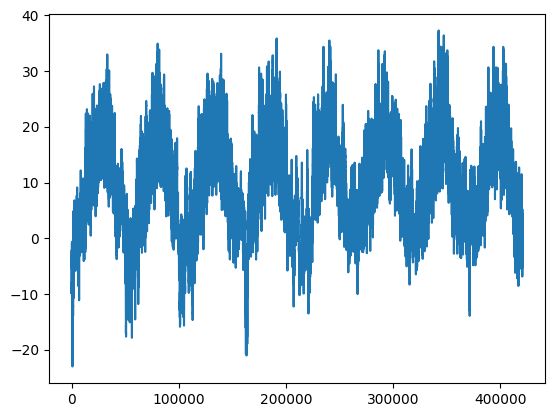

In [25]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

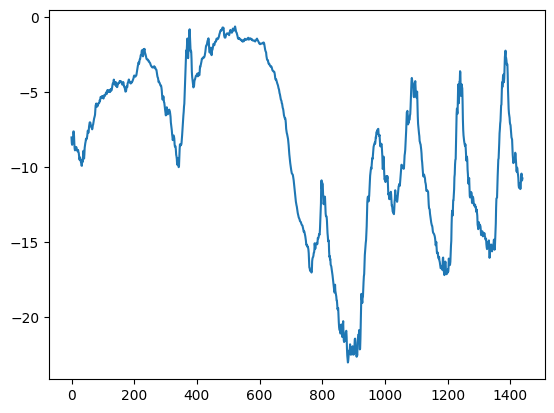

In [27]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [43]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [44]:
# normalize the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [45]:
import numpy as np 
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3], 
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,  
)

In [46]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [47]:
sampling_rate = 6 
sequence_length = 120 
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256 
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [36]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [48]:
def evaluate_naive_method(dataset):
    total_abs_err = 0. 
    samples_seen = 0 
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [50]:
# Training and evaluating a densely connected mode
from tensorflow import keras 
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Reshape((sequence_length * raw_data.shape[-1],))(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
] 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=10,
            validation_data=val_dataset,
            callbacks=callbacks)
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - loss: 21.2422 - mae: 3.4733 - val_loss: 10.4765 - val_mae: 2.5544
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 9.4190 - mae: 2.4191 - val_loss: 10.2569 - val_mae: 2.5289
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - loss: 8.6850 - mae: 2.3198 - val_loss: 10.2001 - val_mae: 2.5187
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 8.2563 - mae: 2.2629 - val_loss: 9.9044 - val_mae: 2.4698
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 7.9322 - mae: 2.2209 - val_loss: 10.5465 - val_mae: 2.5568
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 7.6918 - mae: 2.1857 - val_loss: 11.3605 - val_mae: 2.6671
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - loss: 7.4750 - mae: 2.1566 - val_loss: 10.9342 - val_mae: 2.6099
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - loss: 7.2791 - mae: 2.1292 - val_loss: 10.6525 - val_mae: 2.5704
Epoch 9/10
819/819 ━━━━━━━━━━━━━

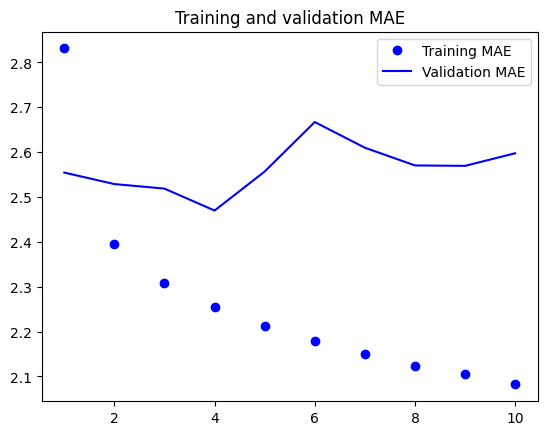

In [51]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [52]:
#  1D convolutional model
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
   save_best_only=True)
 ]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=10,
            validation_data=val_dataset,
            callbacks=callbacks)
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - loss: 33.4013 - mae: 4.4248 - val_loss: 14.5296 - val_mae: 3.0299
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - loss: 17.7544 - mae: 3.3209 - val_loss: 14.1790 - val_mae: 2.9788
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - loss: 15.6707 - mae: 3.1260 - val_loss: 15.7403 - val_mae: 3.1509
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - loss: 14.2699 - mae: 2.9998 - val_loss: 14.4694 - val_mae: 3.0073
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - loss: 13.5615 - mae: 2.9213 - val_loss: 14.0547 - val_mae: 2.9711
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - loss: 13.0878 - mae: 2.8685 - val_loss: 14.8367 - val_mae: 3.0327
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 12.6208 - mae: 2.8156 - val_loss: 16.5237 - val_mae: 3.2360
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - loss: 12.2775 - mae: 2.7764 - val_loss: 14.4512 - val_mae: 3.0005
Epoch 9/10
819/819 ━━━━━

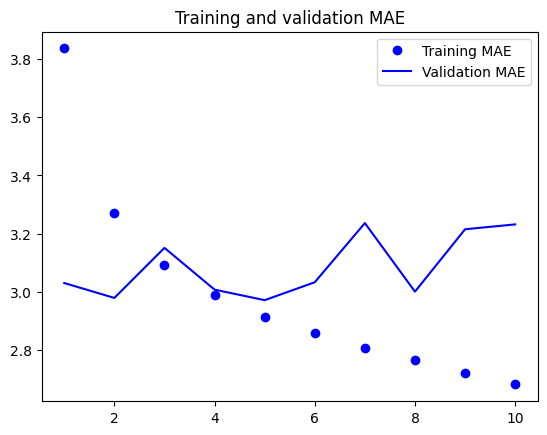

In [53]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [54]:
#  A simple LSTM-based model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
   save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=10,
            validation_data=val_dataset,
            callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 56ms/step - loss: 70.9714 - mae: 6.4220 - val_loss: 12.3871 - val_mae: 2.6988
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 11.8848 - mae: 2.6688 - val_loss: 10.0761 - val_mae: 2.4590
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 50s 61ms/step - loss: 10.1017 - mae: 2.4776 - val_loss: 9.7717 - val_mae: 2.4287
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 57s 70ms/step - loss: 9.8436 - mae: 2.4423 - val_loss: 10.0175 - val_mae: 2.4498
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 9.5528 - mae: 2.4043 - val_loss: 9.9609 - val_mae: 2.4433
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 46s 56ms/step - loss: 9.3129 - mae: 2.3701 - val_loss: 9.9214 - val_mae: 2.4411
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 9.1050 - mae: 2.3468 - val_loss: 9.8920 - val_mae: 2.4398
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 51s 62ms/step - loss: 8.8939 - mae: 2.3200 - val_loss: 9.9554 - val_mae: 2.4457
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

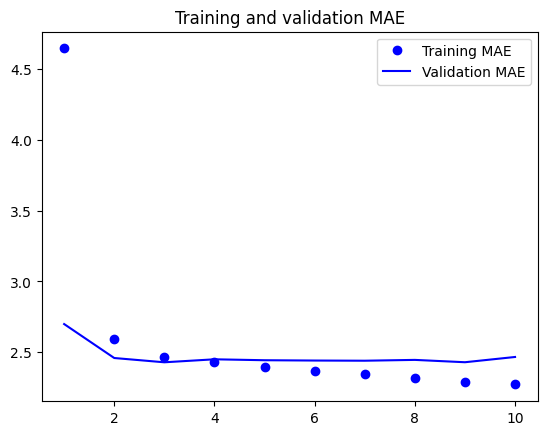

In [56]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
# Training and evaluating a dropout-regularized LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
   save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=50,
            validation_data=val_dataset,
            callbacks=callbacks)  

In [ ]:
#  Training and evaluating a dropout-regularized, stacked GRU model
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
   save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=50,
            validation_data=val_dataset,
            callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
#  Training and evaluating a bidirectional LSTM
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
            epochs=10,
            validation_data=val_dataset)


## Combine Conv1D and GRU (CNN-RNN Hybrid)

In [58]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# 1D Conv for feature extraction
x = layers.Conv1D(16, 3, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 3, activation="relu")(x)

# Feed into GRU
x = layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
callbacks = [keras.callbacks.ModelCheckpoint("best_cnn_gru.keras", save_best_only=True)]

history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("best_cnn_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 52ms/step - loss: 389.4974 - mae: 9.2582 - val_loss: 54.7258 - val_mae: 5.8267
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - loss: 55.6331 - mae: 4.5366 - val_loss: 13.2221 - val_mae: 2.8522
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - loss: 31.6299 - mae: 3.3534 - val_loss: 12.0022 - val_mae: 2.7111
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 45s 55ms/step - loss: 61.2263 - mae: 3.1701 - val_loss: 10.1293 - val_mae: 2.4787
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 48s 58ms/step - loss: 138.0247 - mae: 3.0949 - val_loss: 10.7192 - val_mae: 2.5482
405/405 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 11.6693 - mae: 2.6726
Test MAE: 2.68


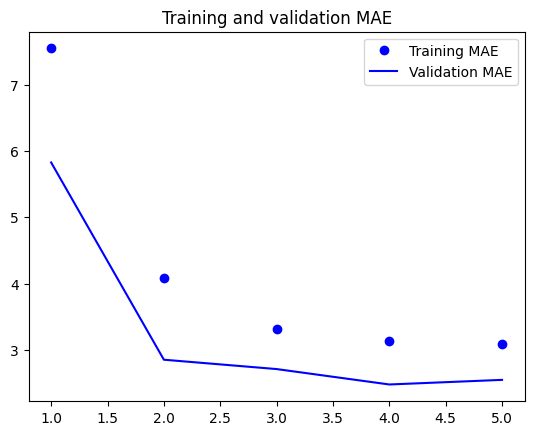

In [59]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Try a Deeper LSTM

In [60]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64, dropout=0.3, recurrent_dropout=0.3)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
callbacks = [keras.callbacks.ModelCheckpoint("deep_lstm.keras", save_best_only=True)]

history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("deep_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 144s 174ms/step - loss: 34.3076 - mae: 4.3385 - val_loss: 9.4118 - val_mae: 2.3858
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 149s 182ms/step - loss: 14.8257 - mae: 3.0068 - val_loss: 9.7478 - val_mae: 2.4263
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 140s 171ms/step - loss: 14.3281 - mae: 2.9531 - val_loss: 9.5724 - val_mae: 2.4003
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 159s 194ms/step - loss: 13.8547 - mae: 2.9017 - val_loss: 9.5489 - val_mae: 2.3974
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 135s 165ms/step - loss: 13.5044 - mae: 2.8653 - val_loss: 9.5979 - val_mae: 2.4013
405/405 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - loss: 10.8293 - mae: 2.5766
Test MAE: 2.58


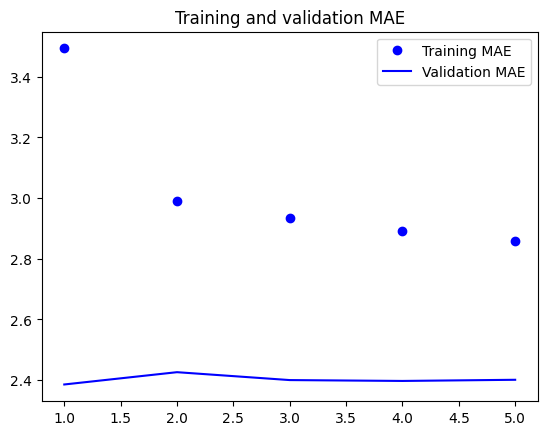

In [61]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Stacked LSTM + Dropout

In [63]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, return_sequences=True, recurrent_dropout=0.3)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.3)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
callbacks = [keras.callbacks.ModelCheckpoint("stacked_lstm.keras", save_best_only=True)]

history = model.fit(train_dataset, epochs=5, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("stacked_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 164s 197ms/step - loss: 46.6529 - mae: 5.0435 - val_loss: 9.4533 - val_mae: 2.3751
Epoch 2/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 177s 216ms/step - loss: 14.4797 - mae: 2.9576 - val_loss: 9.5611 - val_mae: 2.3905
Epoch 3/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 183s 223ms/step - loss: 13.3812 - mae: 2.8298 - val_loss: 8.9568 - val_mae: 2.3055
Epoch 4/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 183s 223ms/step - loss: 12.5623 - mae: 2.7454 - val_loss: 8.8561 - val_mae: 2.2921
Epoch 5/5
819/819 ━━━━━━━━━━━━━━━━━━━━ 187s 228ms/step - loss: 11.8904 - mae: 2.6681 - val_loss: 8.8860 - val_mae: 2.2974
405/405 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 9.9684 - mae: 2.4779 
Test MAE: 2.48


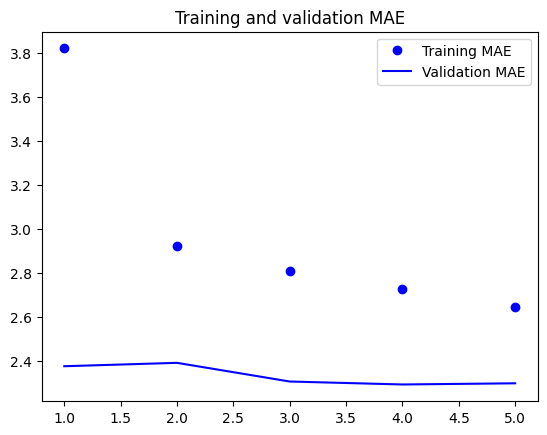

In [64]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()